In [1]:
import torch
import torch.distributed as dist
from mpi4py import MPI

def mpi_test():
    rank = dist.get_rank()
    size = dist.get_world_size()

    print(f"Hello from rank {rank} out of {size} processes!")

if __name__ == "__main__":
    dist.init_process_group(backend="mpi")
    mpi_test()
    dist.destroy_process_group()


RuntimeError: Distributed package doesn't have MPI built in. MPI is only included if you build PyTorch from source on a host that has MPI installed.

In [41]:

mesh=UnitSquareMesh(16,16) #Point(0,0), Point(10,3)

# left Omega
class OmegaLeft(SubDomain):
    def inside(self, x, on_boundary):
        return x[0] <= 0.5
omegaL = OmegaLeft()

subdomains = MeshFunction('size_t', mesh, mesh.topology().dim())
subdomains.set_all(0)
omegaL.mark(subdomains, 1)
#dx = Measure('dx')[subdomains]

submesh_omegaL = SubMesh(mesh, subdomains, 1)
# -------------------------------------------------
# define boundaries for the subdomain
class LeftBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and abs(x[0]) > 0.5 - DOLFIN_EPS
class OtherLeftBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and not abs(x[0]) > 0.5 - DOLFIN_EPS
left_boundary = LeftBoundary()
oleft_boundary = OtherLeftBoundary()

omegaL_boundaries = MeshFunction('size_t', submesh_omegaL, submesh_omegaL.topology().dim()-1)
omegaL_boundaries.set_all(0)
left_boundary.mark(omegaL_boundaries, 1)

# right Omega
class OmegaRight(SubDomain):
    def inside(self, x, on_boundary):
        return x[0] >= 0.5
omegaR = OmegaRight()

subdomains = MeshFunction('size_t', mesh, mesh.topology().dim())
subdomains.set_all(0)
omegaR.mark(subdomains, 2)
#dx = Measure('dx')[subdomains]

submesh_omegaR = SubMesh(mesh, subdomains, 2)
# -------------------------------------------------
# define boundaries for the subdomain
class RightBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and abs(x[0]) < 0.5 + DOLFIN_EPS
class OtherRightBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and not abs(x[0]) < 0.5 + DOLFIN_EPS
right_boundary = RightBoundary()

omegaR_boundaries = MeshFunction('size_t', submesh_omegaR, submesh_omegaR.topology().dim()-1)
omegaR_boundaries.set_all(0)
right_boundary.mark(omegaR_boundaries, 1)


#ds_omegaL = Measure('ds')[omegaL_boundaries]

 # Load mesh
# meshfile = "data/mesh/DD" 
# mesh = Mesh(meshfile + ".xml")
# bounds = MeshFunction("size_t", mesh, meshfile + "_facet_region.xml")


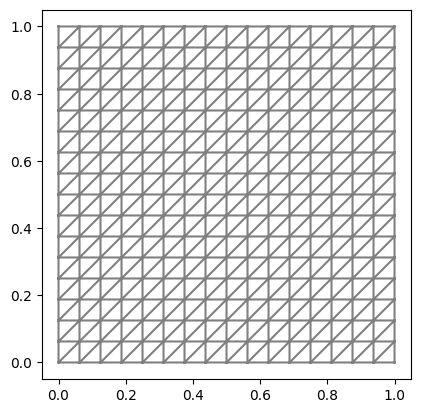

In [42]:
plot(mesh)

In [43]:
#Timevariables

alpha = 30
beta = 12
dt=Constant(0.3)
t=float(dt)
T=1.8
g_expr='1+x[0]*x[0]+alpha*x[1]*x[1]+beta*t'
g=Expression(g_expr,alpha=alpha,beta=beta,t=0,degree=2)
print(g._cpp_object)

        Solving linear variational problem.
        Solving linear variational problem.
          Building point search tree to accelerate distance queries.
          Computed bounding box tree with 511 nodes for 256 points.


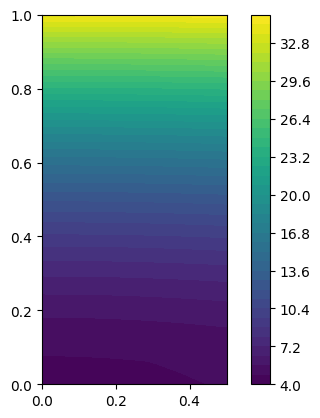

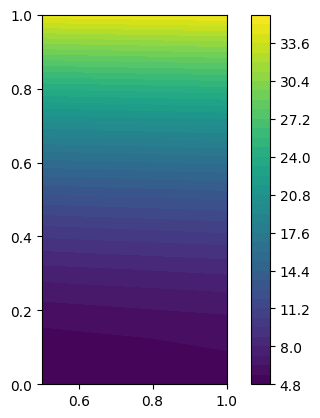

        Solving linear variational problem.
        Solving linear variational problem.


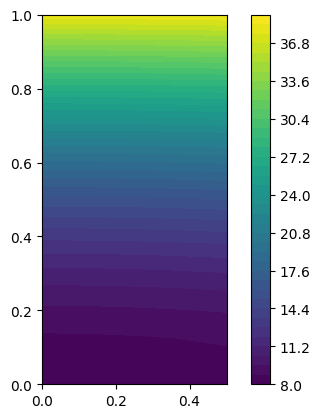

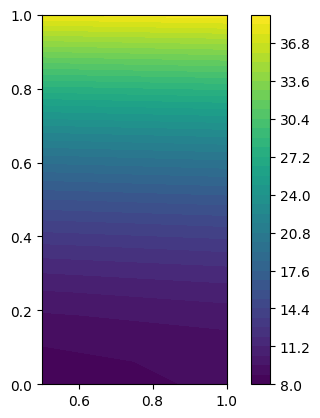

        Solving linear variational problem.
        Solving linear variational problem.


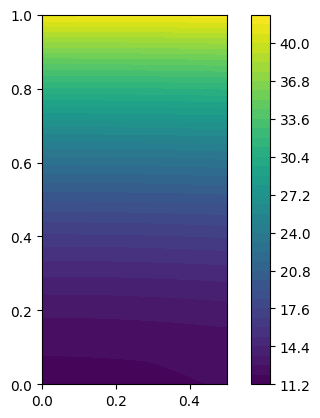

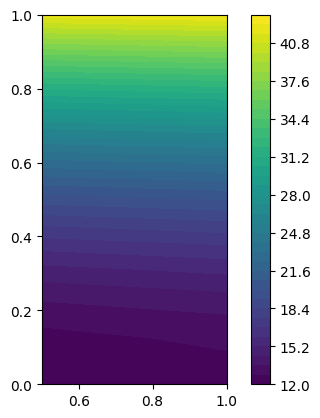

        Solving linear variational problem.
        Solving linear variational problem.


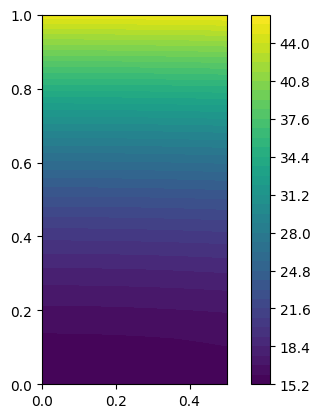

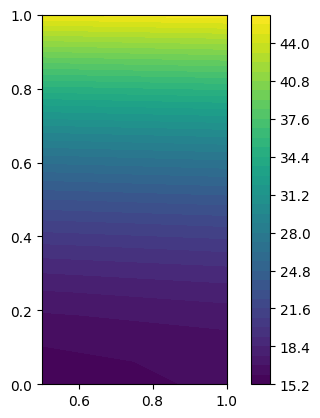

        Solving linear variational problem.
        Solving linear variational problem.


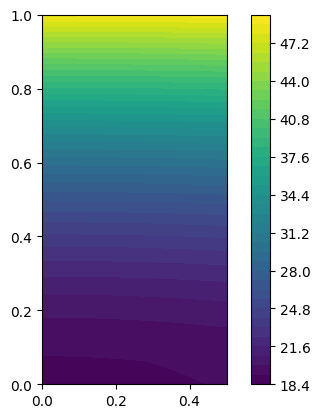

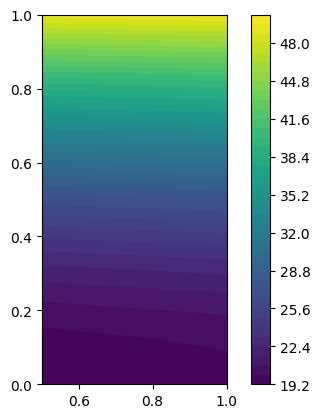

        Solving linear variational problem.
        Solving linear variational problem.


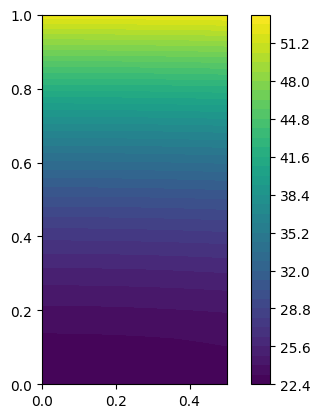

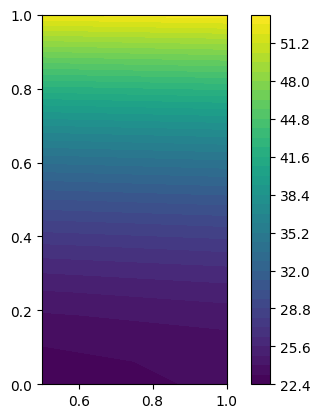

In [44]:

V1=FunctionSpace(submesh_omegaL,"CG",1)
V2=FunctionSpace(submesh_omegaR,"CG",1)
V = FunctionSpace(mesh,"CG",1)
u0l=interpolate(g,V1)
u0r=interpolate(g,V2)
u1=Function(V1)
u2=Function(V2)

#Variationalproblemateachtime
ul=TrialFunction(V1)
vl=TestFunction(V1)
fl=Constant(beta - 2 - 2*alpha)
al=ul*vl*dx+dt*inner(grad(ul),grad(vl))*dx
Ll=u0l*vl*dx+dt*fl*vl*dx

ur=TrialFunction(V2)
vr=TestFunction(V2)
fr=Constant(beta - 2 - 2*alpha)
ar=ur*vr*dx+dt*inner(grad(ur),grad(vr))*dx
Lr=u0r*vr*dx+dt*fr*vr*dx
# bc_x=DirichletBC(V,g,bounds,5)
# bc_xtreme=DirichletBC(V,g,bounds,6)
# bc_left=DirichletBC(V,u0,bounds,7)
# bc_right=DirichletBC(V,u0,bounds,8)
# bcs = [bc_x,bc_xtreme,bc_left,bc_right]

bcs0l = DirichletBC(V1,g,omegaL_boundaries,0)
#bcs0r = DirichletBC(V2,g,omegaR_boundaries,0)
#bcs1l = DirichletBC(V1,g,omegaL_boundaries,1)
bcs1r = DirichletBC(V2,g,omegaR_boundaries,1)

bcsl = [bcs0l]
bcsr = [bcs1r]

while(t<=T):
    #Solve
    g.t=t
    solve(al==Ll,u1,bcsl)
    u1.set_allow_extrapolation(True)

    bcs0r = DirichletBC(V2,u1,omegaR_boundaries,0)

    solve(ar==Lr,u2,[bcs0r,bcs1r])
    #Update
    u0l.assign(u1)
    u0r.assign(u2)
    sol = plot(u1)
    plot(u1)
    plt.colorbar(sol)
    plt.show()
    sol = plot(u2)
    plot(u2)
    plt.colorbar(sol)
    plt.show()
    t+=float(dt)

/tmp/ipykernel_1158/3716001351.py:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1); p = plot(u1)


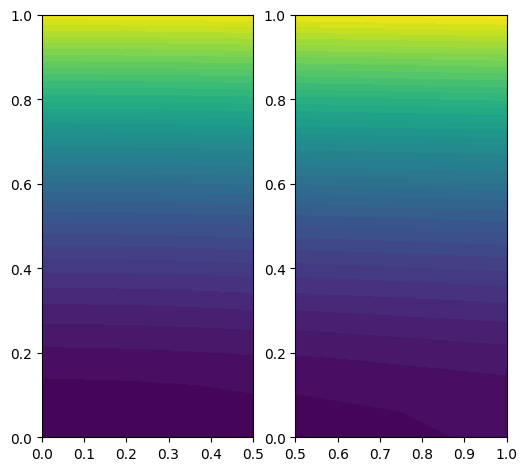

In [45]:
pl, ax = plt.subplots(); fig = plt.gcf(); fig.set_size_inches(6, 6); 
plt.subplot(1, 2, 1); p = plot(u1)
plt.subplot(1, 2, 2); p = plot(u2)

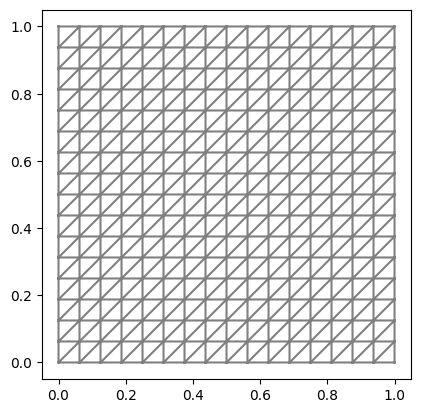

In [46]:
plot(mesh)